In [1]:
from financetoolkit import Toolkit
import pandas as pd
import numpy as np

stockinfo = Toolkit('MSFT', api_key="0265080a2d6590ff848ec3cc090c3ecb")

firmdata = stockinfo.get_enterprise()
price = stockinfo.get_historical_data(start='2019-01-01', end='2023-06-01')
BS = stockinfo.get_balance_sheet_statement()
IS = stockinfo.get_income_statement()
CFS = stockinfo.get_cash_flow_statement()
years = BS.columns
rating = stockinfo.get_rating()
dupont = stockinfo.models.get_extended_dupont_analysis()
liquidity = stockinfo.ratios.collect_liquidity_ratios()
efficiency = stockinfo.ratios.collect_efficiency_ratios()
profit = stockinfo.ratios.collect_profitability_ratios()

<ipython-input-1-815f75cc55f1>:5: DeprecationWarning: This version of the Finance Toolkit is depreciated. Finance Toolkit 1.0.3 and onwards require Python 3.10 and higher. Please update to the latest version of Python and the Finance Toolkit.
  stockinfo = Toolkit('MSFT', api_key="0265080a2d6590ff848ec3cc090c3ecb")


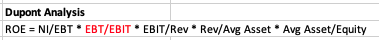

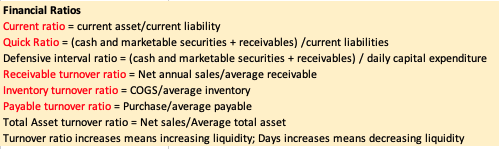

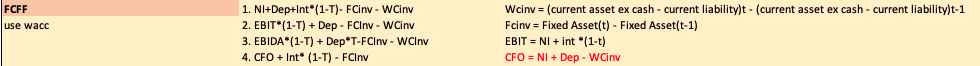

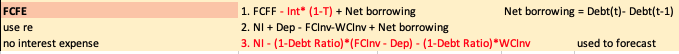 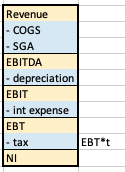


In [2]:
#BS
securities = BS[years[-1]]['Short Term Investments']
securities_last = BS[years[-2]]['Short Term Investments']
current_assets = BS[years[-1]]['Total Current Assets']
current_assets_last = BS[years[-2]]['Total Current Assets']
current_liabilities = BS[years[-1]]['Total Current Liabilities']
current_liabilities_last = BS[years[-2]]['Total Current Liabilities']
acct_receivable = BS[years[-1]]['Accounts Receivable']
acct_receivable_last = BS[years[-2]]['Accounts Receivable']
working_capital = current_assets - current_liabilities
ppe = BS[years[-1]]['Property, Plant and Equipment']
ppe_last = BS[years[-2]]['Property, Plant and Equipment']

total_assets = BS[years[-1]]['Total Assets']
total_assets_last = BS[years[-2]]['Total Assets']
lt_debt = BS[years[-1]]['Long Term Debt']
lt_debt_last = BS[years[-2]]['Long Term Debt']
total_liabilities = BS[years[-1]]['Total Liabilities']

total_debt = BS[years[-1]]['Total Debt']
total_debt_last = BS[years[-2]]['Total Debt']
mv = firmdata['Market Capitalization'][-1:][years[-1]]
retained_earnings = BS[years[-1]]['Retained Earnings']

#IS
sales = IS[years[-1]]['Revenue']
sales_last = IS[years[-2]]['Revenue']
cogs = IS[years[-1]]['Cost of Goods Sold']
cogs_last = IS[years[-2]]['Cost of Goods Sold']
sga = IS[years[-1]]['Selling, General and Administrative Expenses']
sga_last = IS[years[-2]]['Selling, General and Administrative Expenses']
depreciation = IS[years[-1]]['Depreciation and Amortization']
depreciation_last = IS[years[-2]]['Depreciation and Amortization']

EBIT = IS[years[-1]]['EBITDA'] - IS[years[-1]]['Depreciation and Amortization']
net_income = IS[years[-1]]['Net Income']
net_income_last = IS[years[-2]]['Net Income']
#CFS
ffo = CFS[years[-1]]['Cash Flow from Operations']

#Ratios
gross_margin = profit[years[-1]]['Gross Margin']
gross_margin_last = profit[years[-2]]['Gross Margin']
roa = profit[years[-1]]['Return on Assets (ROA)']
roa_last = profit[years[-2]]['Return on Assets (ROA)']
roe = profit[years[-1]]['Return on Equity (ROE)']
current_ratio = liquidity[years[-1]]['Current Ratio']
current_ratio_last = liquidity[years[-2]]['Current Ratio']

asset_turnover = efficiency[years[-1]]['Asset Turnover Ratio']
asset_turnover_last = efficiency[years[-2]]['Asset Turnover Ratio']


#firm
div = CFS[years[-1]]['Dividends Paid']
ts = firmdata['Number of Shares'].iloc[-1]
ts_last = firmdata['Number of Shares'][years[-2]]
sgr = (net_income + div)/net_income * roe 

# Piotroski F-score - earning quality
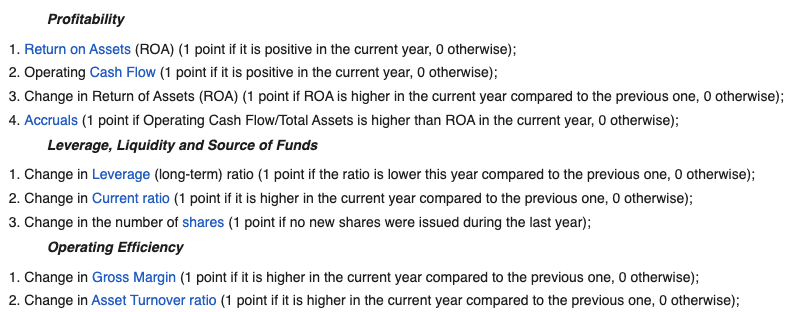

In [3]:
s_1 = 1 if roa > 0 else 0
s_2 = 1 if ffo > 0 else 0
s_3 = 1 if roa > roa_last else 0
s_4 = 1 if (ffo / total_assets) > roa else 0
s_5 = 1 if total_debt < total_debt_last else 0
s_6 = 1 if current_ratio > current_ratio_last else 0
s_7 = 1 if ts < ts_last else 0
s_8 = 1 if gross_margin > gross_margin_last else 0
s_9 = 1 if asset_turnover > asset_turnover_last else 0
S = s_1+ s_2 + s_3 + s_4 + s_5 + s_6 + s_7 + s_8 + s_9
print(S) # 7-9, means good

7


# Beneish M-score - accounting manipulation
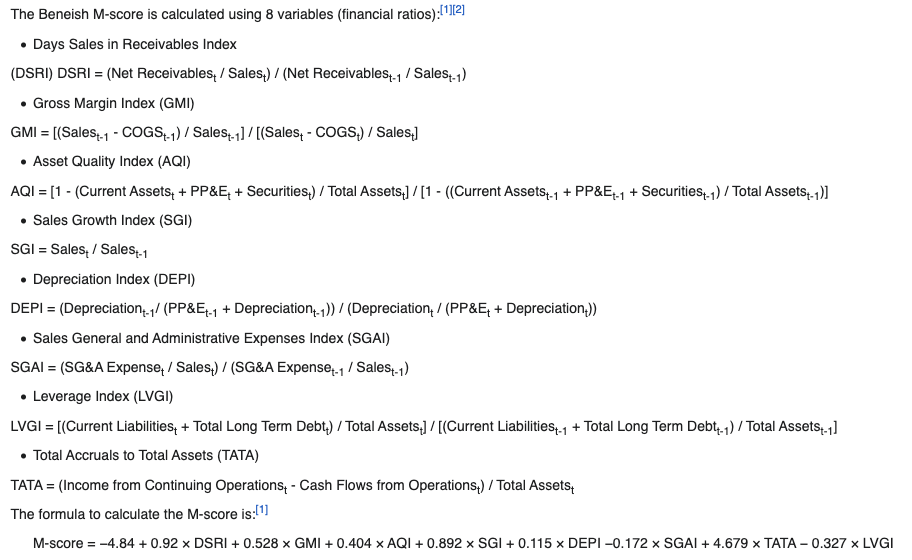

In [4]:
DSRI = (acct_receivable/sales)/(acct_receivable_last/sales_last)
GMI = ((sales_last - cogs_last)/sales_last)/((sales - cogs)/sales)
AQI = (1-(current_assets + ppe + securities) / total_assets)/(1-(current_assets_last + ppe_last + securities_last)/total_assets_last)
SGI = sales / sales_last
DEPI = (depreciation_last/ (ppe_last + depreciation_last))/((depreciation/(ppe + depreciation)))
SGAI = (sga/sales)/(sga_last/sales_last)
LVGI = ((current_liabilities + lt_debt ) / total_assets)/((current_liabilities_last + lt_debt_last) / total_assets)
TATA = ( net_income - ffo) / total_assets
M = -4.84 + 0.92 * DSRI + 0.528 * GMI + 0.404 * AQI + 0.892 * SGI \
+ 0.115 * DEPI - 0.172 * SGAI + 0.4679 * TATA - 0.327 * LVGI

print(M) #if m > 1.78, likely a manipulator

-2.918407215976707


# Altman Z-score - bankruptcy
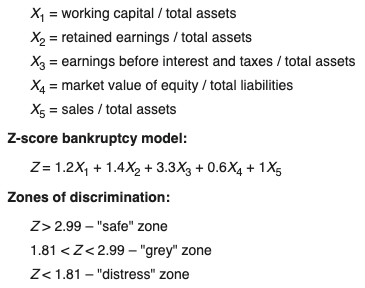

In [5]:
x_1 = working_capital/ total_assets
x_2 = retained_earnings/ total_assets
x_3 = EBIT / total_assets
x_4 = mv / total_liabilities
x_5 = sales / total_assets
Z = 1.2*x_1 + 1.4*x_2 +3.3*x_3 + 0.6*x_4 +1*x_5
print(Z) # Z > 2.99 means safe

7.691598975007276


# Ohlson O-score - bankruptcy
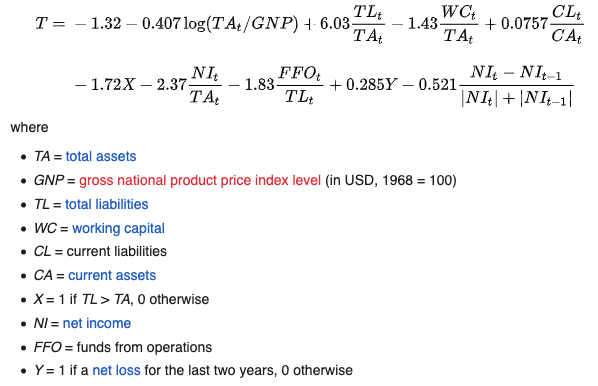

In [6]:
import pandas_datareader as pdr
fred = pdr.data.DataReader('GNP', data_source='fred')
GNP = fred['GNP'][-1:][0]
GNP = GNP * (10 **9)

X = 1 if total_liabilities > total_assets else 0
Y = 1 if (net_income < 0) and (net_income_last < 0) else 0 
T = - 1.32 - 0.407 * np.log(total_assets/GNP) + 0.63 * total_liabilities/total_assets \
- 1.43 * working_capital/total_assets + 0.0757 * current_liabilities/ current_assets - 1.72 * X\
- 2.37 * net_income/total_assets - 1.83 * ffo/total_liabilities + 0.285* Y \
- 0.521 * (net_income - net_income_last)/(abs(net_income)+abs(net_income_last))

P = np.exp(T)/(1+np.exp(T)) 
print(P) # <0.5 means good

0.3056102221289995
